# MyoPS 2020 Challenge

Ideas: 
 - load data via torchio
 - include meaningful augmentations
 - retrain base network (U-Net, resnet34)
 - use fastai2
 - use all labels (incl. LV, MY, RV)
 - use cross validation on training set to estimate performance

In [1]:
!pip install fastai2 kornia

In [2]:
!pip install git+https://github.com/Project-MONAI/MONAI#egg=MONAI

In [3]:
from fastai2.vision.all import *
from fastai2.vision.models import resnet34
from monai.losses import FocalLoss
import gc

### fastai U-Net on these static images

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = "/content/drive/My Drive/miccai2020/myops/png"

In [6]:
np.random.seed(42)
ids = np.arange(101,151)
np.random.shuffle(ids)
ids = np.reshape(ids,(-1,10))
ids

array([[114, 140, 131, 146, 118, 149, 127, 126, 133, 120],
       [113, 105, 138, 109, 104, 107, 142, 147, 148, 116],
       [110, 117, 125, 135, 132, 101, 145, 128, 134, 106],
       [130, 112, 137, 102, 122, 103, 144, 136, 124, 141],
       [111, 123, 119, 150, 121, 108, 143, 115, 129, 139]])

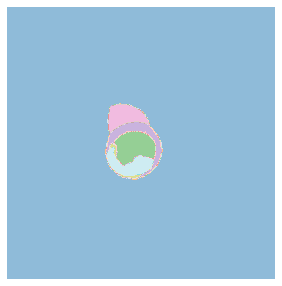

In [7]:
one_mask = PILMask.create('/content/drive/My Drive/miccai2020/myops/png/masks/125-orig-1.png')
one_mask.show()

In [8]:
ToTensor()(one_mask)

TensorMask([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

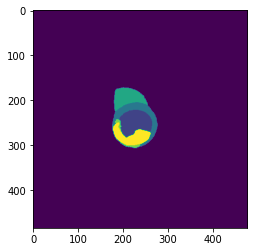

In [9]:
plt.imshow(ToTensor()(one_mask))

Use cropping instead of resizing

In [10]:
class AddMaskCodeMapping(Transform):
    "Add mapping of pixel value to class for a `TensorMask`"
    def __init__(self, mapping, codes=None):
        #print("init")
        self.mapping = mapping
        self.codes = codes
        if codes is not None: self.vocab,self.c = codes,len(codes)

    def encodes(self, o:PILMask):
        #print("encodes")
        mo = ToTensor()(o)
        mo = mo.to(dtype=torch.long)
        mo = self.mapping.index_select(0,mo.flatten()).reshape(*mo.shape)
        mo = PILMask.create(mo.to(dtype=torch.uint8))
        return mo
    
    def decodes(self, o:TensorMask):
        #print("decodes")
        if self.codes is not None: o._meta = {'codes': self.codes}
        return o

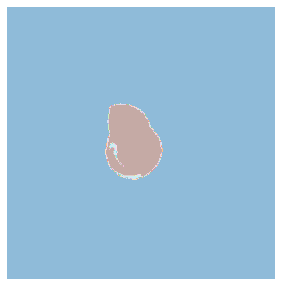

In [11]:
AddMaskCodeMapping(mapping = torch.LongTensor([0,1,1,1,2,1]), codes = ['bg','heart','ed'])(one_mask).show()

In [12]:
def MappedMaskBlock(mapping,codes=None):
    "A `TransformBlock` for segmentation masks, with mapping of pixel values to classes, potentially with `codes`"
    return TransformBlock(type_tfms=PILMask.create, item_tfms=AddMaskCodeMapping(mapping=mapping,codes=codes), batch_tfms=IntToFloatTensor)

In [13]:
def getMyopsDls(val_ids):
  myopsData = DataBlock(blocks=(ImageBlock, MappedMaskBlock(mapping = torch.LongTensor([0,1,1,1,2,1]), codes = ['bg','heart','ed'])),#['bg','lv','my','rv','ed','sc'])),
      get_items=get_image_files,
      splitter=FuncSplitter(lambda o: int(o.name.split("-")[0]) in val_ids),
      get_y=lambda o: str(o).replace("images","masks"),
      item_tfms=CropPad(256),
      batch_tfms=aug_transforms(max_rotate=90))
  return myopsData.dataloaders(f'{path}/images',num_workers=8,batch_size=16)

In [14]:
dl = getMyopsDls(ids[0])

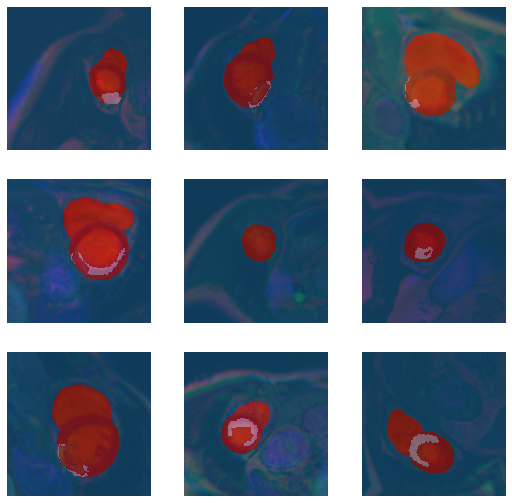

In [15]:
dl.show_batch(vmin=0)

In [16]:
batch = dl.one_batch()

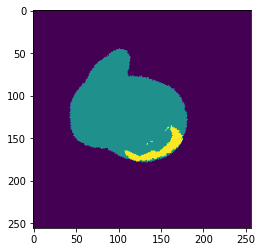

In [18]:
plt.imshow(batch[1][1].cpu().detach())

In [19]:
np.unique(batch[1][1].cpu().detach(),return_counts=True)

(array([0, 1, 2]), array([53313, 11472,   751]))

**Attention!** The cropped version can have masks close to the edge and zooming or rotation can lead to additional masks at the edge because of padding in reflection mode

In [20]:
def multi_dice(input:Tensor, targs:Tensor, class_id=0, inverse=False)->Tensor:
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    # replace all with class_id with 1 all else with 0 to have binary case
    output = (input == class_id).float()
    # same for targs
    targs = (targs.view(n,-1) == class_id).float()
    if inverse:
        output = 1 - output
        targs = 1 - targs
    intersect = (output * targs).sum(dim=1).float()
    union = (output+targs).sum(dim=1).float()
    res = 2. * intersect / union
    res[torch.isnan(res)] = 1
    return res.mean()

def diceHeart(input, targs): return multi_dice(input,targs,class_id=1)
def diceEdema(input, targs): return multi_dice(input,targs,class_id=2)
dices = [diceHeart,diceEdema]

In [21]:
monaiFocal = FocalLoss(weight=torch.Tensor([.1,.3,.6]),reduction='mean')
def myFocal(input, target):
  return monaiFocal(input, target.unsqueeze(1))

In [22]:
def standard_trained_learner_cv(dl):
  learn = unet_learner(
    dl,
    resnet34,
    #loss_func=myFocal,
    metrics=[foreground_acc, *dices],
    cbs=CSVLogger(fname="/content/drive/My Drive/miccai2020/myops/04_edOnly_unet_resnet34.trainLog.csv",append=True)
  )
  learn.lr_find()
  learn.fit_one_cycle(15,lr_max=1e-3)
  learn.unfreeze()
  learn.lr_find()
  learn.fit_one_cycle(15,lr_max=1e-4)
  return learn

epoch,train_loss,valid_loss,foreground_acc,diceHeart,diceEdema,time
0,0.336603,0.145109,0.749962,0.769043,0.214286,02:06
1,0.195840,0.113062,0.732887,0.806847,0.214286,01:06
2,0.147474,0.113584,0.925109,0.828296,0.214286,01:05
3,0.121619,0.079488,0.898241,0.885206,0.214286,01:05
4,0.101063,0.066208,0.852337,0.898922,0.214286,01:05
5,0.090232,0.060945,0.903267,0.904122,0.214330,01:05
6,0.083647,0.074214,0.935038,0.882578,0.214286,01:05
7,0.080105,0.056197,0.900634,0.907659,0.214286,01:05
8,0.073005,0.056772,0.900004,0.908803,0.215179,01:05
9,0.069141,0.057999,0.875974,0.907330,0.215847,01:05


epoch,train_loss,valid_loss,foreground_acc,diceHeart,diceEdema,time
0,0.053331,0.054144,0.891168,0.910005,0.283781,01:08
1,0.052400,0.054324,0.891776,0.910747,0.217798,01:08
2,0.055256,0.056584,0.863541,0.901712,0.227173,01:08
3,0.054797,0.061057,0.848272,0.899888,0.217288,01:08
4,0.053811,0.053788,0.888410,0.910820,0.248230,01:08
5,0.052081,0.053761,0.908920,0.907936,0.296634,01:08
6,0.050638,0.054455,0.902553,0.911474,0.211384,01:08
7,0.049021,0.053403,0.892881,0.911146,0.263982,01:08
8,0.047439,0.052268,0.895293,0.913407,0.250768,01:08
9,0.045104,0.051880,0.886588,0.905715,0.274699,01:08


epoch,train_loss,valid_loss,foreground_acc,diceHeart,diceEdema,time
0,0.343775,0.192687,0.891082,0.760312,0.208333,01:13
1,0.210491,0.118913,0.706899,0.793814,0.208333,01:03
2,0.156742,0.088275,0.870075,0.874093,0.208333,01:03
3,0.129399,0.086088,0.858348,0.875195,0.208333,01:03
4,0.111750,0.081481,0.909070,0.887784,0.208396,01:03
5,0.095186,0.071993,0.888236,0.893991,0.202423,01:02
6,0.085668,0.079470,0.919274,0.876924,0.208333,01:02
7,0.079414,0.074853,0.914780,0.890097,0.192262,01:02
8,0.073725,0.078829,0.899803,0.886164,0.131826,01:02
9,0.069022,0.071341,0.897591,0.897328,0.196349,01:02


epoch,train_loss,valid_loss,foreground_acc,diceHeart,diceEdema,time
0,0.053640,0.070408,0.901348,0.896339,0.199401,01:05
1,0.054049,0.079951,0.917134,0.892254,0.202276,01:05
2,0.055856,0.073208,0.876943,0.886565,0.189762,01:05
3,0.056090,0.078161,0.900763,0.885381,0.154181,01:05
4,0.055137,0.071004,0.897980,0.885451,0.160457,01:05
5,0.053224,0.072518,0.897521,0.896787,0.226743,01:05
6,0.050636,0.067282,0.878843,0.892247,0.213191,01:05
7,0.049145,0.071343,0.897547,0.892076,0.192194,01:05
8,0.047486,0.068680,0.906593,0.899444,0.221642,01:05
9,0.045709,0.073874,0.912638,0.896171,0.225203,01:05


epoch,train_loss,valid_loss,foreground_acc,diceHeart,diceEdema,time
0,0.456331,0.144953,0.685060,0.753968,0.173913,01:12
1,0.256511,0.106618,0.723127,0.804156,0.173913,01:03
2,0.187798,0.121479,0.906088,0.820916,0.173913,01:03
3,0.143686,0.092623,0.901483,0.860365,0.174056,01:03
4,0.127920,0.077892,0.815359,0.868688,0.173913,01:03
5,0.107864,0.072450,0.811198,0.868464,0.149195,01:03
6,0.095451,0.062229,0.880710,0.897244,0.168999,01:02
7,0.088598,0.061994,0.866728,0.888764,0.173913,01:02
8,0.082349,0.057969,0.874953,0.901304,0.168471,01:02
9,0.076460,0.055021,0.882344,0.902339,0.177280,01:02


epoch,train_loss,valid_loss,foreground_acc,diceHeart,diceEdema,time
0,0.059578,0.055116,0.879117,0.903430,0.243422,01:05
1,0.059560,0.066029,0.819468,0.881172,0.215803,01:05
2,0.059540,0.061461,0.866656,0.896949,0.240286,01:05
3,0.061976,0.058301,0.878794,0.901007,0.263972,01:05
4,0.060782,0.063214,0.862709,0.894056,0.268376,01:05
5,0.057898,0.061761,0.889822,0.894144,0.197674,01:05
6,0.055356,0.089341,0.866405,0.896856,0.253789,01:05
7,0.054326,0.055333,0.875347,0.896615,0.219398,01:05
8,0.051635,0.057081,0.862245,0.898343,0.256650,01:05
9,0.049273,0.055977,0.889090,0.908142,0.249233,01:05


epoch,train_loss,valid_loss,foreground_acc,diceHeart,diceEdema,time
0,0.317030,0.167235,0.771427,0.788271,0.050000,01:09
1,0.195730,0.122917,0.875134,0.848507,0.050000,01:03
2,0.146863,0.118766,0.743375,0.819741,0.052871,01:03
3,0.122525,0.089919,0.853642,0.886572,0.052123,01:03
4,0.111673,0.085324,0.844323,0.884154,0.050000,01:03
5,0.096462,0.090574,0.828379,0.864915,0.050000,01:03
6,0.086569,0.086318,0.896566,0.896378,0.058815,01:02
7,0.078588,0.083046,0.864656,0.893854,0.050277,01:03
8,0.072660,0.074110,0.852759,0.885971,0.050000,01:03
9,0.069573,0.074913,0.855534,0.890068,0.053202,01:03


epoch,train_loss,valid_loss,foreground_acc,diceHeart,diceEdema,time
0,0.054048,0.069001,0.866793,0.896009,0.134456,01:05
1,0.054772,0.076077,0.875813,0.896623,0.086919,01:05
2,0.053954,0.073236,0.879481,0.893657,0.143460,01:05
3,0.055599,0.069426,0.856516,0.896889,0.090843,01:05
4,0.055345,0.072916,0.876972,0.894843,0.238147,01:05
5,0.053364,0.071347,0.855833,0.901484,0.109746,01:05
6,0.051106,0.071393,0.880238,0.907529,0.120072,01:05
7,0.048217,0.068058,0.885269,0.910353,0.146346,01:05
8,0.047457,0.067697,0.861257,0.895291,0.260470,01:05
9,0.046070,0.070741,0.872068,0.906593,0.147732,01:05


epoch,train_loss,valid_loss,foreground_acc,diceHeart,diceEdema,time
0,0.262077,0.172848,0.687899,0.755366,0.095238,01:11
1,0.178689,0.388729,0.055143,0.100012,0.095238,01:04
2,0.156245,0.177129,0.682290,0.765956,0.096333,01:04
3,0.118104,0.115301,0.846314,0.855557,0.095238,01:03
4,0.097690,0.120478,0.833905,0.853336,0.095238,01:03
5,0.090523,0.104118,0.825628,0.854368,0.129766,01:03
6,0.082864,0.100190,0.856270,0.867541,0.095238,01:03
7,0.074562,0.090205,0.865584,0.882595,0.101559,01:03
8,0.070104,0.097723,0.829792,0.876698,0.095309,01:03
9,0.067410,0.092222,0.880146,0.879152,0.130896,01:03


epoch,train_loss,valid_loss,foreground_acc,diceHeart,diceEdema,time
0,0.053305,0.084975,0.875272,0.886184,0.206207,01:06
1,0.052294,0.084898,0.875029,0.888241,0.181389,01:06
2,0.052537,0.082341,0.863867,0.881605,0.203566,01:06
3,0.052448,0.088486,0.865696,0.887278,0.183514,01:06
4,0.051727,0.084535,0.833605,0.865782,0.218433,01:06
5,0.049830,0.101026,0.860392,0.875790,0.177032,01:06
6,0.048237,0.089763,0.859485,0.872833,0.204231,01:06
7,0.047387,0.083139,0.864472,0.878920,0.210608,01:06
8,0.045615,0.086106,0.863826,0.879167,0.210844,01:06
9,0.044081,0.084033,0.843292,0.874716,0.197231,01:06


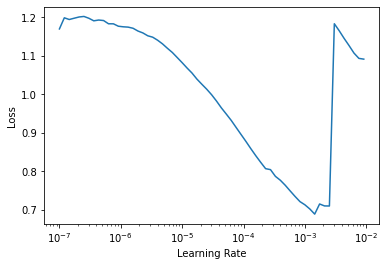

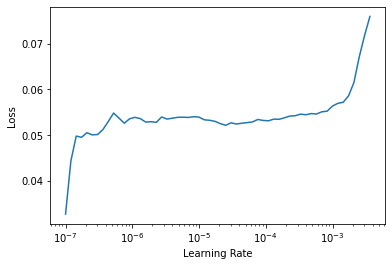

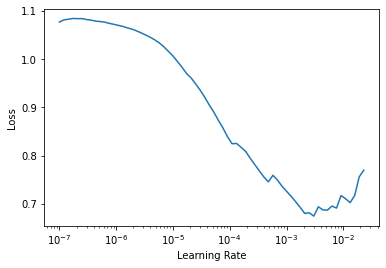

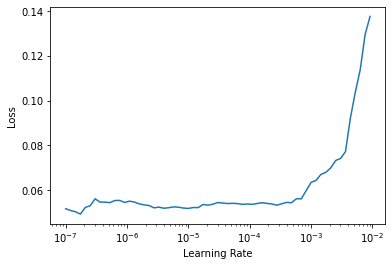

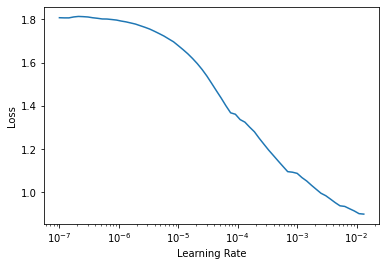

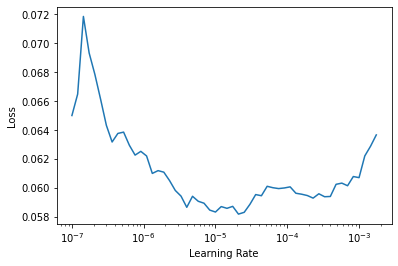

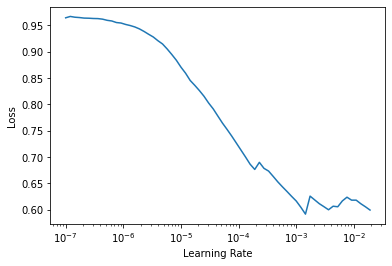

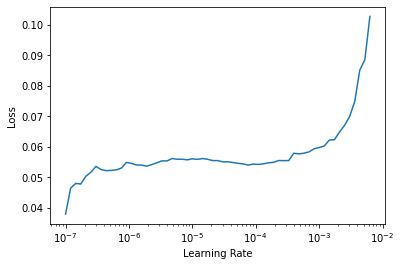

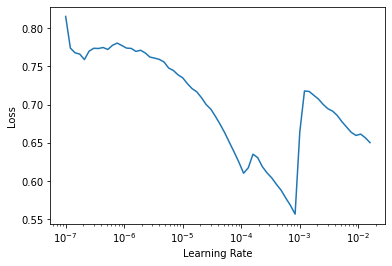

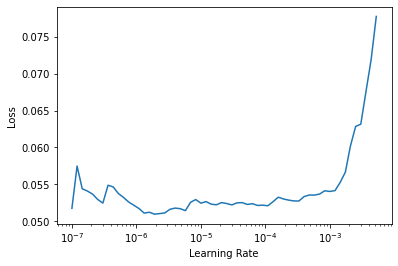

In [23]:
cv_results = list()
learn = None
dl = None
for x in ids:
  del learn
  del dl
  gc.collect()
  torch.cuda.empty_cache()
  dl = getMyopsDls(x)
  learn = standard_trained_learner_cv(dl)
  cv_results.append(learn.validate())

In [24]:
cv_results = pd.DataFrame(cv_results, columns=learn.recorder.metric_names[2:-1])
cv_results

,valid_loss,foreground_acc,diceHeart,diceEdema
0,0.054160,0.897286,0.908958,0.194340
1,0.072798,0.905275,0.899351,0.233780
2,0.056889,0.882553,0.908912,0.268345
3,0.068366,0.876262,0.908018,0.189838
4,0.086645,0.869549,0.890273,0.180329


In [25]:
cv_results.to_csv('/content/drive/My Drive/miccai2020/myops/04_edOnly_unet_resnet34.cv_results.csv', index=False)

In [26]:
cv_results.mean()

valid_loss        0.067772
foreground_acc    0.886185
diceHeart         0.903102
diceEdema         0.213326
dtype: float64

In [27]:
cv_results_long = cv_results.stack().reset_index()
cv_results_long.columns = ['cv', 'metric', 'value']

In [28]:
import altair as alt

In [29]:
(alt.Chart(cv_results_long)
  .mark_point()
  .encode(x='metric', y='value', color='cv:N')
  .properties(width=600, height=300)
  .interactive())

alt.Chart(...)

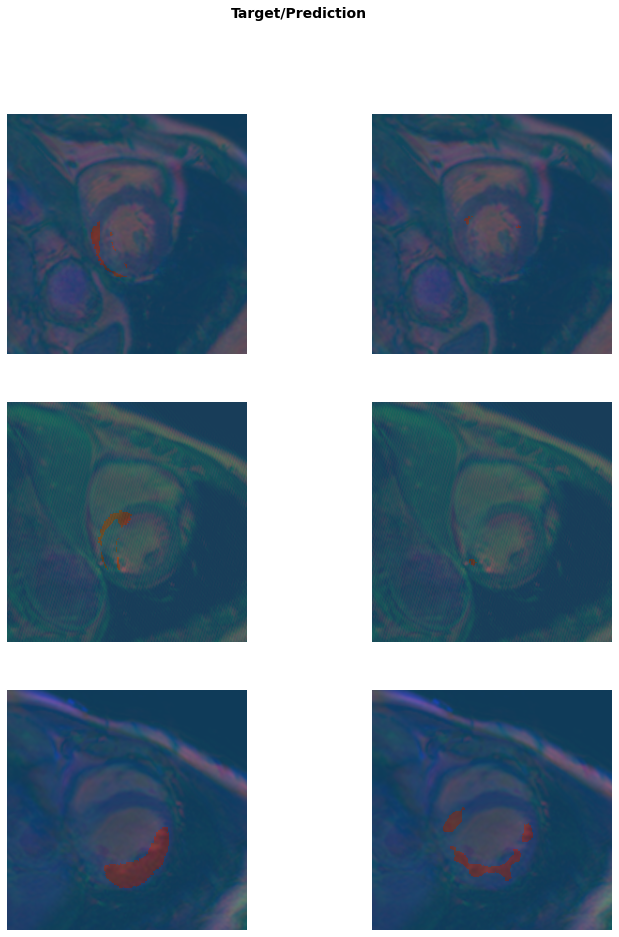

In [30]:
learn.show_results(figsize=(12,15))

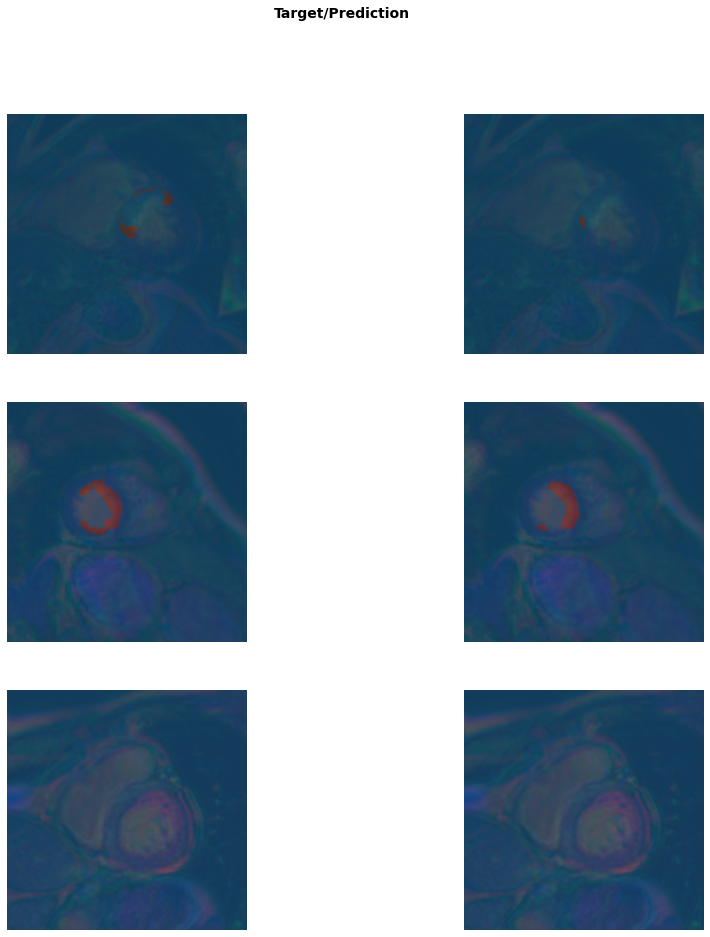

In [31]:
learn.show_results(ds_idx=0, figsize=(15,15))

In [ ]:
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [ ]:
%%R

library(tidyverse)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Parsed with column specification:
cols(
  valid_loss = col_double(),
  foreground_acc = col_double(),
  diceLV = col_double(),
  diceMY = col_double(),
  diceRV = col_double(),
  diceEd = col_double(),
  diceSc = col_double()
)



# A tibble: 5 x 7
  valid_loss foreground_acc diceLV diceMY diceRV diceEd diceSc
       <dbl>          <dbl>  <dbl>  <dbl>  <dbl>  <dbl>  <dbl>
1    0.00792          0.786  0.860  0.745  0.824  0.278  0.549
2    0.00905          0.787  0.866  0.699  0.817  0.217  0.431
3    0.00739          0.768  0.858  0.720  0.752  0.249  0.498
4    0.00807          0.798  0.885  0.697  0.851  0.269  0.538
5    0.0110           0.751  0.859  0.664  0.796  0.271  0.513


In [ ]:
%%R
read_cv_results <- function(name) {
    return(
        read_csv(paste0("/content/drive/My Drive/miccai2020/myops/",name,".cv_results.csv")) %>%
          mutate(cv=as_factor(row_number()),name=name)
    )
}
cv_res <- bind_rows(
    read_cv_results("00_simple_unet_resnet34"),
    read_cv_results("00_crop_unet_resnet34"),
    read_cv_results("03_crop_focal_unet_resnet34"),
    read_cv_results("03_crop_focal2_unet_resnet34"),
    read_cv_results("03_crop_focal3_unet_resnet34"),
)

cv_res

R[write to console]: Parsed with column specification:
cols(
  valid_loss = col_double(),
  foreground_acc = col_double(),
  diceLV = col_double(),
  diceMY = col_double(),
  diceRV = col_double(),
  diceEd = col_double(),
  diceSc = col_double()
)

R[write to console]: Parsed with column specification:
cols(
  valid_loss = col_double(),
  foreground_acc = col_double(),
  diceLV = col_double(),
  diceMY = col_double(),
  diceRV = col_double(),
  diceEd = col_double(),
  diceSc = col_double()
)

R[write to console]: Parsed with column specification:
cols(
  valid_loss = col_double(),
  foreground_acc = col_double(),
  diceLV = col_double(),
  diceMY = col_double(),
  diceRV = col_double(),
  diceEd = col_double(),
  diceSc = col_double()
)

R[write to console]: Parsed with column specification:
cols(
  valid_loss = col_double(),
  foreground_acc = col_double(),
  diceLV = col_double(),
  diceMY = col_double(),
  diceRV = col_double(),
  diceEd = col_double(),
  diceSc = col_double()
)



# A tibble: 25 x 9
   valid_loss foreground_acc diceLV diceMY diceRV diceEd diceSc cv    name      
        <dbl>          <dbl>  <dbl>  <dbl>  <dbl>  <dbl>  <dbl> <fct> <chr>     
 1     0.0257          0.798  0.878  0.746  0.866  0.240  0.487 1     00_simple…
 2     0.0288          0.803  0.865  0.726  0.837  0.150  0.433 2     00_simple…
 3     0.0275          0.775  0.863  0.743  0.772  0.286  0.496 3     00_simple…
 4     0.0311          0.800  0.897  0.726  0.854  0.221  0.518 4     00_simple…
 5     0.0367          0.758  0.852  0.670  0.795  0.223  0.425 5     00_simple…
 6     0.0852          0.805  0.880  0.778  0.829  0.247  0.491 1     00_crop_u…
 7     0.105           0.818  0.874  0.744  0.819  0.136  0.428 2     00_crop_u…
 8     0.0893          0.789  0.879  0.757  0.787  0.295  0.524 3     00_crop_u…
 9     0.0979          0.812  0.897  0.727  0.848  0.185  0.511 4     00_crop_u…
10     0.123           0.773  0.873  0.699  0.811  0.253  0.494 5     00_crop_u…
# … with 

In [ ]:
%%R
cv_res %>% group_by(name) %>% select(-cv) %>% summarize_all(mean)

# A tibble: 5 x 8
  name              valid_loss foreground_acc diceLV diceMY diceRV diceEd diceSc
  <chr>                  <dbl>          <dbl>  <dbl>  <dbl>  <dbl>  <dbl>  <dbl>
1 00_crop_unet_res…    0.100            0.799  0.881  0.741  0.819  0.223  0.489
2 00_simple_unet_r…    0.0300           0.787  0.871  0.722  0.825  0.224  0.472
3 03_crop_focal_un…    0.0237           0.793  0.881  0.737  0.809  0.220  0.501
4 03_crop_focal2_u…    0.0126           0.798  0.877  0.738  0.806  0.253  0.513
5 03_crop_focal3_u…    0.00868          0.778  0.866  0.705  0.808  0.257  0.506


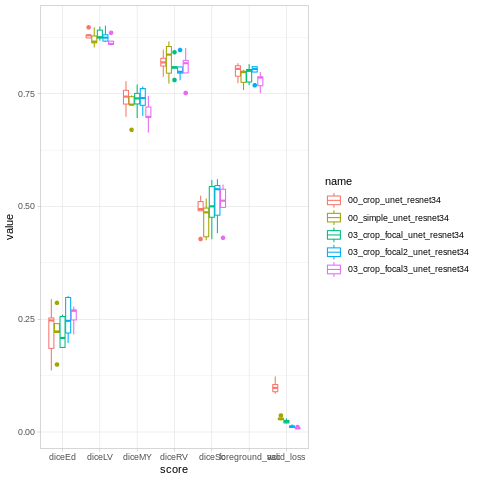

In [ ]:
%%R
cv_res %>%
  gather("score","value",valid_loss:diceSc) %>%
  ggplot(aes(score,value,color=name)) +
  geom_boxplot() +
  theme_light()

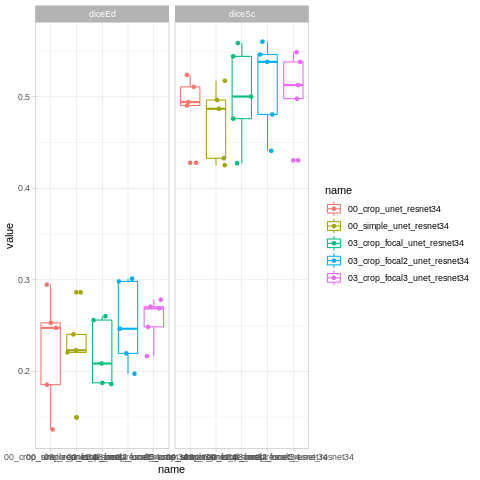

In [ ]:
%%R
cv_res %>%
  gather("score","value",valid_loss:diceSc) %>%
  filter(score %in% c("diceSc","diceEd")) %>%
  ggplot(aes(name,value,color=name)) +
  geom_boxplot() +
  geom_jitter() +
  facet_wrap(score ~ .) +
  theme_light()

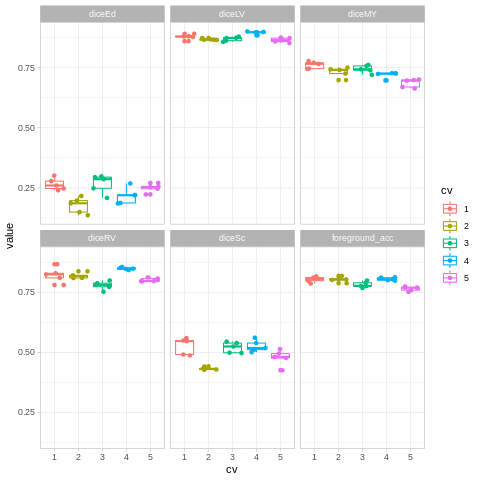

In [ ]:
%%R
cv_res %>%
  gather("score","value",valid_loss:diceSc) %>%
  filter(score != "valid_loss") %>%
  ggplot(aes(cv,value,color=cv)) +
  geom_boxplot() +
  geom_jitter() +
  facet_wrap(score ~ .) +
  theme_light()